In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy.matlib import repmat

from timeit import default_timer as timer

import tqdm

import scipy

In [2]:
# Turn and recover vector for encoding

def encode(var_dictionary):
    result_concat = np.concatenate([var_dictionary[v].ravel() for v in var_dictionary.keys()])
    return result_concat


def decode(var_vector, var_dictionary):
    result_decoded = {}
    var_idx = [var_dictionary[v].ravel().shape[0] for v in var_dictionary.keys()]

    current_index = 0
    dictionary_names = list(var_dictionary.keys())
    
    for idx in np.arange(len(dictionary_names)):
        result_index = current_index + var_idx[idx]
        result_decoded[dictionary_names[idx]] = np.reshape(var_vector[current_index:result_index], 
                                                           var_dictionary[dictionary_names[idx]].shape)
        
        current_index = result_index
        
    return result_decoded

In [71]:
class FunctionCompilation():
    # feval equivalent
    def callFunction(self, name, val):
        fn = getattr(self, name, None)
        if fn is not None:
            return fn(val)
        else:
            print('Undefined function call')
            return
        
        
    def ackley(self, val):
        dim = val.shape[1]
        
        f1 = np.sum([val[:, :1 + dim]**2], axis=-1)
        f1 = np.reshape(f1, (f1.shape[1], f1.shape[0]))
        f2 = np.sum([np.cos(2*np.pi * val[:, :1+dim])], axis=-1)
        f2 = np.reshape(f2, (f2.shape[1], f2.shape[0]))
        
        return -20 * np.exp(-0.2 * np.sqrt(1/dim * f1)) - np.exp(1/dim * f2) + 20 + np.exp(1)
    
    
    def eso_obj(self, val):
        par = val['par']
        
        vals = val['var']
        
        obj_value = []
        for i in np.arange(vals.shape[0]):
            var = decode(vals[i, :], val['var_names'])
            temp_gens = sum([var['genActPower'][g, t] * par['genLimit'][g, t, 2] + var['genExcActPower'][g, t] * par['genLimit'][g, t, 4]
                             for t in np.arange(par['t'][-1]) for g in np.arange(par['gen'][-1])])
            
            temp_loads = sum([var['loadRedActPower'][l, t] * par['loadLimit'][l, t, 6] + var['loadCutActPower'][l, t] * par['loadLimit'][l, t, 7] + var['loadENS'][l, t] * par['loadLimit'][l, t, 9] 
                              for t in np.arange(par['t'][-1]) for l in np.arange(par['load'][-1])])
        
            temp_rest = sum([var['pImp'][i] * par['buyPrice'][i] - var['pExp'][i] * par['sellPrice'][i] 
                             for i in np.arange(par['t'][-1])])
            
            obj_value.append(temp_gens + temp_loads + temp_rest)
            
        obj_value = np.reshape(obj_value, (vals.shape[0], 1))
        
        return obj_value

In [4]:
class DEParams(object):
    
    def __init__(self, I_itermax=5e5, I_NP=50, F_weight=0.5, F_CR=0.9, I_bnd_constr=3, param_dictionary=None):
        
        ## Set parameters for HyDE-DF
        self.I_itermax = I_itermax
        self.I_NP = I_NP
        self.F_weight = F_weight
        self.F_CR = F_CR
        
        self.param_dictionary = None
        
        self.I_bnd_constr = I_bnd_constr #Using bound constraints is possible to change direct in DE
        # 1 repair to the lower or upper violated bound
        # 2 rand value in the allowed range
        # 3 bounce back
        
        
class OtherParameters(object):
    
    def __init__(self, objfun, dim, lowerlimit, upperlimit, var_dictionary=None, param_dictionary=None):
        self.objfun = objfun
        self.dim = dim
        self.lowerlimit = lowerlimit
        self.upperlimit = upperlimit
        
        self.var_dictionary = var_dictionary
        self.param_dictionary = param_dictionary

In [5]:
# Check population aux

def check_pop(val, par, val_dictionary):
    # Decode the solution vector
    pop = decode(val, val_dictionary)
    
    # Bound the boolean variables
    pop['genXo'] = (pop['genXo'] > 0.5).astype(int)
    pop['loadXo'] = (pop['loadXo'] > 0.5).astype(int)

    # Go through generators
    for g in np.arange(pop['genActPower'].shape[0]):
        
        # Check generator type
        if par['genInfo'][g, 4] != 1:
            
            for t in np.arange(pop['genActPower'].shape[1]):
                # Maximum generation in generators with normal contract
                if pop['genActPower'][g, t] > par['genLimit'][g, t, 0]:
                    pop['genActPower'][g, t] = par['genLimit'][g, t, 0]
                
                # Minimum generation in generators with normal contract
                #if ((pop['genXo'][g, t] == 0) & (par['genInfo'][g, 6] > 0)):
                    # If there is a minimum generation in place we set the boolean to 1
                    #pop['genXo'][g, t] = 1
                    #if pop['genActPower'] < par['genInfo'][g, 6]:
                        #pop['genActPower'][g, t] = par['genInfo'][g, 6]
                if pop['genActPower'][g, t] < par['genInfo'][g, 6] * pop['genXo'][g, t]:
                    pop['genActPower'][g, t] = par['genInfo'][g, 6]
                
        elif par['genInfo'][g, 4] != 2:
            # Generate the genExcActPower variable according to the equality equation
            pop['genExcActPower'][g, :] = par['genLimit'][g, :, 0] - pop['genActPower'][g, :]
            
            # Set possible negative values to 0
            pop['genExcActPower'][g, :][pop['genExcActPower'][g, :] < 0] = 0
            
    # Go through the loads
    for l in np.arange(pop['loadRedActPower'].shape[0]):
        
        # Timesteps
        for t in np.arange(pop['loadRedActPower'].shape[1]):
            
            # Check load reduction
            if pop['loadRedActPower'][l, t] > par['loadLimit'][l, t, 2]:
                pop['loadRedActPower'][l, t] = par['loadLimit'][l, t, 2]
                
            #pop['loadCutActPower'][l, t] = par['loadLimit'][l, t, 3]
            pop['loadCutActPower'][l, t] = par['loadLimit'][l, t, 3] * pop['loadXo'][l, t]
            
            temp_val = par['loadActPower'][l, t] - pop['loadRedActPower'][l, t] - pop['loadCutActPower'][l, t]
            if pop['loadENS'][l, t] > temp_val:
                pop['loadENS'][l, t] = temp_val
            
    return encode(pop)

In [79]:
# HyDE-DF implementation

def HyDE_DF(deParameters, otherParameters, initialSolution):
    
    # Generate population
    def genpop(a, b, lowMatrix, upMatrix):
        temp = np.random.uniform(low=lowMatrix, high=upMatrix, size=(a, b))
        temp[np.where(temp < 0)] = 0
        #print(temp)
        return np.random.uniform(low=lowMatrix, high=upMatrix, size=(a, b))
    
    
    # Trial generation
    def generate_trial(F_weight, F_CR, FM_pop, FVr_bestmemit, I_NP, I_D, FVr_rot, linear_decrease):
    
        # Save the old population
        FM_popold = FM_pop

        # Index pointer array
        FVr_ind = np.random.permutation(np.arange(5))

        # Shuffle locations of vectors
        FVr_a1 = np.random.permutation(np.arange(I_NP))

        # Rotate indices by ind[0] positions
        FVr_rt = (FVr_rot + FVr_ind[0]) % I_NP

        # Rotate vector locations
        FVr_a2 = FVr_a1[FVr_rt]

        # Shuffled population 1
        FM_pm1 = FM_popold[FVr_a1, :]

        # Shuffled population 2
        FM_pm2 = FM_popold[FVr_a2, :]
        
        FM_mpo = None

        # Meaning the same F_CR for all individuals
        if len(F_CR) == 1:

            # All random numbers < F_CR are 1, 0 otherwise
            FM_mui = (np.random.normal(size=(I_NP, I_D)) < F_CR).astype(int)

            # Inverse mask to FM_mui
            FM_mpo = (FM_mui < 0.5).astype(int)

        # Meaning a different F_CR for each individual
        else:
            # All random numbers < F_CR are 1, 0 otherwise
            FM_mui = (np.random.normal(size=(I_NP, I_D)) < repmat(F_CR, 1, I_D)).astype(int)

            # Inverse mask to FM_mui
            FM_mpo = FM_mui < 0.5


        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% 
        FM_bm = repmat(FVr_bestmemit, I_NP, 1)

        # Linear decrease
        a = linear_decrease

        # Exponential decreasing function
        ginv = np.exp(1-(1/a**2)) 


        #differential variation
        repmat0 = np.reshape(repmat(F_weight[:, 2], 1, I_D), (F_weight.shape[0], I_D))
        repmat1 = np.reshape(repmat(F_weight[:, 0], 1, I_D), (F_weight.shape[0], I_D))
        repmat2 = np.reshape(repmat(F_weight[:, 1], 1, I_D), (F_weight.shape[0], I_D))
        
        diff_var = ginv * (repmat1 * (FM_bm * (repmat2 + np.random.normal(size=(I_NP, I_D)) - FM_popold)))

        FM_ui = FM_popold + repmat0 * (FM_pm1 - FM_pm2) + diff_var

        FM_ui = FM_popold * FM_mpo + FM_ui * FM_mui
        FM_base = FM_bm
        #msg = 'HyDE-DF'
        #print(msg)

        return FM_ui, FM_base, None
    
    
    # Update aux function        
    def _update(p, lowMatrix, upMatrix, BRM, FM_base):
        #print(p.shape)
        if BRM == 1: # Our method
            # [popsize, dim] = size(p)
            idx = np.where(p < lowMatrix)
            p[idx[0], idx[1]] = lowMatrix[idx]

            idx = np.where(p > upMatrix)
            p[idx] = upMatrix[idx]
        elif BRM == 2: # Random initialization - DOES NOT WORK
            idx = [np.where(p < lowMatrix), np.where(p > upMatrix)]
            replace = np.random.uniform(low=lowMatrix[idx[0][0], idx[0][1]], 
                                        high=upMatrix[idx[1][0], idx[1][1]], 
                                        size=(len(idx), 1))
            p[idx] = replace
        elif BRM == 3: # Bounce-back
            idx = np.where(p < lowMatrix)
            new_val = np.random.uniform(low=lowMatrix[idx[0], idx[1]], 
                                        high=FM_base[idx[0], idx[1]], 
                                        size=(len(idx[0]), len(idx[1])))
            if new_val.shape[0] > 0:
                p[idx[0], idx[1]] = new_val[:, 0]
                
                
            idx = np.where(p > upMatrix)
            new_val = np.random.uniform(low=FM_base[idx[0], idx[1]], 
                                        high=upMatrix[idx[0], idx[1]], 
                                        size=(len(idx[0]), len(idx[1])))
            if new_val.shape[0] > 0:
                p[idx[0], idx[1]] = new_val[:, 0]
                
            for member in np.arange(p.shape[0]):
                p[member] = check_pop(p[member], 
                                      otherParameters.param_dictionary, 
                                      otherParameters.var_dictionary)

        return p
    
    
    #-----This is just for notational convenience and to keep the code uncluttered.--------
    I_NP = deParameters.I_NP
    F_weight = deParameters.F_weight
    F_CR = deParameters.F_CR
    I_D = otherParameters.dim     #Number of variables or dimension
    deParameters.nVariables = I_D
    #FVr_minbound = otherParameters.lowerlimit * np.array(np.ones((1,otherParameters.dim)))
    #FVr_maxbound = otherParameters.upperlimit * np.array(np.ones((1,otherParameters.dim)))
    
    FVr_minbound = otherParameters.lowerlimit
    FVr_maxbound = otherParameters.upperlimit
    
    I_itermax = deParameters.I_itermax
    
    
    #Repair boundary method employed
    BRM = deParameters.I_bnd_constr   #1: bring the value to bound violated
                                      #2: repair in the allowed range
                                      #3: Bounce-back
            
    # Get Objective Function
    fnc = otherParameters.objfun
    
    # Function caller initialization
    fn_obj = FunctionCompilation()
    
    #-----Check input variables---------------------------------------------
    if I_NP < 5:
        I_NP = 5
        print('I_NP increased to minimal value 5\n')
    
    if (F_CR < 0) | (F_CR > 1):
        F_CR = 0.5
        print('F_CR should be from interval [0, 1] - set to default value 0.5\n')
        
    if I_itermax <= 0:
        I_itermax = 200
        print('I_itermax should be > 0 - set to default value 200\n')
    
    
    #-----Initialize population and some arrays-------------------------------
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # pre-allocation of loop variables
    fitMaxVector = np.empty((1, I_itermax))
    fitMaxVector[:] = np.nan
    
    
    # limit iterations by threshold
    #gen = 0; #iterations
    
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #----FM_pop is a matrix of size I_NPx(I_D+1). It will be initialized------
    #----with random values between the min and max values of the-------------
    #----parameters-----------------------------------------------------------
    # FLC modification - vectorization
    minPositionsMatrix = repmat(FVr_minbound, I_NP, 1)
    maxPositionsMatrix = repmat(FVr_maxbound, I_NP, 1)
    deParameters.minPositionsMatrix = minPositionsMatrix
    deParameters.maxPositionsMatrix = maxPositionsMatrix
    
    # generate initial population.
    FM_pop = genpop(I_NP, I_D, minPositionsMatrix, maxPositionsMatrix)
    
    #If you want to inject initial solutions
    if initialSolution != None: 
        noInitialSolutions = initialSolution.shape[0]
        FM_pop[1:noInitialSolutions, :] = initialSolution
        
        
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #------Evaluate the best member after initialization----------------------
    # Modified by FLC
    #S_val = fn_obj.callFunction(fnc, FM_pop)
    S_val = 0
    if fnc != 'eso_obj':
        S_val = fn_obj.callFunction(fnc, FM_pop)
    else:
        S_val = fn_obj.callFunction(fnc, {'var': FM_pop, 
                                          'par': otherParameters.param_dictionary,
                                          'var_names': otherParameters.var_dictionary})
    I_best_index = np.argmin(S_val); # This mean that the best individual correspond to the best worst performance
    FVr_bestmemit = FM_pop[I_best_index, :] # best member of current iteration
    
    fitMaxVector[:, 0] = S_val[I_best_index] #We save the mean value and mean penalty value
    # The user can decide to save the mean, best, or any other value here
    
    
    #------DE-Minimization------------------------------------------------
    #------FM_popold is the population which has to compete. It is--------
    #------static through one iteration. FM_pop is the newly--------------
    #------emerging population.-------------------------------------------
    FVr_rot  = np.arange(0, I_NP, 1)             # rotating index array (size I_NP)
    
    
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    #% HYDE self-adaptive parameters
    F_weight_old = repmat(F_weight, I_NP, 3)
    F_weight = F_weight_old
    F_CR_old = repmat(F_CR, I_NP, 1)
    F_CR = F_CR_old

    
    #while gen < I_itermax-1:  #%&&  fitIterationGap >= threshold
    for gen in tqdm.tqdm(np.arange(I_itermax)):
        #% Calculate decay function factor a = itr / MaxItr; 
        lin_decr = (I_itermax - gen) / I_itermax


        #% Update HyDE-DF values              
        value_R = np.random.normal(size=(I_NP, 3))
        ind1 = (value_R < 0.1).astype(int)
        ind2 = (np.random.normal(size=(I_NP, 1)) < 0.1).astype(int)
        
        F_weight[:] = F_weight_old[:]
        try:
            F_weight[ind1] = (0.1 + np.random.normal(size=(sum(sum(ind1)), 1)) * 0.9)[0]
        except:
            pass
        
        F_CR[:] = F_CR_old[:]
        try:
            F_CR[ind2] = np.random.normal(size=(sum(ind2)[0], 1))[0]
        except:
            pass
        #except:
        #    F_CR[ind2] = np.random.normal(size=(sum(ind2)[0], 1))
        
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        FM_ui, FM_base, _ = generate_trial(F_weight, F_CR, FM_pop, FVr_bestmemit, I_NP, I_D, FVr_rot, lin_decr)
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
 
        ## Boundary Control
        FM_ui = _update(FM_ui, minPositionsMatrix, maxPositionsMatrix, BRM, FM_base)
        
        ## Evaluation of new Pop
        #S_val_temp = fn_obj.callFunction(fnc, FM_ui)
        
        S_val_temp = 0
        if fnc != 'eso_obj':
            S_val_temp = fn_obj.callFunction(fnc, FM_ui)
        else:
            S_val_temp = fn_obj.callFunction(fnc, {'var': FM_ui, 
                                                   'par': otherParameters.param_dictionary,
                                                   'var_names': otherParameters.var_dictionary})
        
        
        ## Elitist Selection
        ind = np.where(S_val_temp < S_val)
        S_val[ind] = S_val_temp[ind]
        FM_pop[ind, :] = FM_ui[ind, :]
        
        
        ## Update best results
        S_bestval = min(S_val)
        I_best_index = np.argmin(S_val)
        FVr_bestmemit = FM_pop[I_best_index, :]
        
        
        ## Save best parameters (similar to jDE)
        F_weight_old[ind, :] = F_weight[ind, :]
        F_CR_old[ind] = F_CR[ind]
        
        #gen += 1;        
        
        ## Store fitness evolution and obj fun evolution as well
        fitMaxVector[:, gen] = S_bestval
        
        
    Fit_and_p = fitMaxVector[0, gen - 1]
    
    return Fit_and_p, FVr_bestmemit, fitMaxVector

In [ ]:
# Ackley test function

N_RUNS = 30

deParams = DEParams(I_itermax=1000)
otherParams = OtherParameters(objfun='ackley', lowerlimit=-32, upperlimit=32, dim=30)

list_fit_and_p = []
list_bestmemit = []
list_maxvector = []
list_timer = []


print('Starting trials')
for i in tqdm.tqdm(np.arange(N_RUNS)):
    
    # Start timer - https://stackoverflow.com/questions/7370801/how-to-measure-elapsed-time-in-python
    start = timer()
    
    # Do optimization
    fit_and_p, bestmemit, maxvector = HyDE_DF(deParams, otherParams, None)
    
    # End timer
    end = timer()
    
    list_fit_and_p.append(fit_and_p)
    list_bestmemit.append(bestmemit)
    list_maxvector.append(maxvector)
    list_timer.append(end-start)
    

trial_results = pd.DataFrame({'Fit': list_fit_and_p,
                              'Solution': list_bestmemit,
                              'Fit Vector': list_maxvector,
                              'Time': list_timer})

In [32]:
# Show solutions

trial_results

,Fit,Solution,Fit Vector,Time
0,4.440892e-16,"[8.067538839575013e-17, 1.0102278420148729e-16...","[[12.680215272308292, 9.230037763443601, 7.940...",1.594317
1,4.440892e-16,"[2.989314723468193e-18, 3.1904747691016294e-18...","[[10.026588322316547, 8.63917932444925, 6.5478...",1.410325
2,4.440892e-16,"[1.011669887440286e-19, 2.1082889100182894e-19...","[[12.12456883830772, 7.48136130007348, 6.46402...",1.578524
3,4.440892e-16,"[1.3833853054624716e-17, 3.2646258984809907e-1...","[[11.202825859228245, 8.24859334525536, 6.0780...",1.476999
4,4.440892e-16,"[1.67280358833758e-16, 1.3883147850803413e-17,...","[[11.847590434631005, 8.27751040097464, 6.5083...",1.490180
5,4.440892e-16,"[1.1405857769118941e-17, 6.249764723118251e-18...","[[9.210673896055091, 8.132344850905001, 6.5326...",1.394240
6,4.440892e-16,"[4.141240770786869e-17, 9.416082972896572e-18,...","[[9.832453700854533, 8.8482035757292, 7.088868...",1.572959
7,4.440892e-16,"[2.480214853901482e-16, 1.1248741040490515e-17...","[[10.858304376637653, 9.43732390819577, 8.9113...",1.580855
8,4.440892e-16,"[1.0594744899800315e-17, 1.074413304275455e-17...","[[9.098224437376931, 6.910916058693786, 4.6130...",1.335869
9,4.440892e-16,"[1.2813450349080332e-17, 2.5522029969226586e-1...","[[10.170952790675281, 7.108765469117738, 6.851...",1.569394


In [7]:
# loadmat aux function to load the matlab save files
# from: https://stackoverflow.com/review/suggested-edits/21667510

import scipy.io as spio

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _has_struct(elem):
        """Determine if elem is an array and if any array item is a struct"""
        return isinstance(elem, np.ndarray) and any(isinstance(
                    e, scipy.io.matlab.mio5_params.mat_struct) for e in elem)

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif _has_struct(elem):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif _has_struct(sub_elem):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [8]:
# Matlab code conversion

# Read matlab file instead of excelfile (easier conversion)
data = loadmat('matlab.mat')

C:\Users\camar\AppData\Local\Temp\ipykernel_7120\3560610281.py:19: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
C:\Users\camar\AppData\Local\Temp\ipykernel_7120\3560610281.py:35: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(elem, spio.matlab.mio5_params.mat_struct):
C:\Users\camar\AppData\Local\Temp\ipykernel_7120\3560610281.py:26: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  e, scipy.io.matlab.mio5_params.mat_struct) for e in elem)


In [9]:
# Linearize the generator prices

# genCofA=data.generator.limit(:,:,6); -> MATLAB starts with 1, so we need the index -1
# genCofB=data.generator.limit(:,:,7);
# genCofC=data.generator.limit(:,:,8);

genCofA = data['data']['generator']['limit'][:, :, 5]
genCofB = data['data']['generator']['limit'][:, :, 6]
genCofC = data['data']['generator']['limit'][:, :, 7]

In [10]:
# Options for simulation

#options 
iterlim = 1000000000
reslim = 5000000000

In [11]:
# Definir o numero de resources usados

numGen = np.arange(1, data['data']['parameterData']['resources']['numGen'] + 1)
numLoad = np.arange(1, data['data']['parameterData']['resources']['numLoad'] + 1)
numStor = np.arange(1, data['data']['parameterData']['resources']['numStor'] + 1)
numV2G = np.arange(1, data['data']['parameterData']['resources']['numV2G'] + 1)
numCStat = np.arange(1, data['data']['parameterData']['resources']['numCStat'] + 1)
numPeriod = np.arange(1, data['data']['parameterData']['resources']['period'] + 1)
numBus = np.array([1]) #np.arange(1) # forced to 1
nOwner = np.arange(1, data['data']['parameterData']['resources']['owners'] + 1)

In [12]:
# Define as strings com os recursos para mandar para GAMS

gen = np.max(numGen)
Load = np.max(numLoad)
stor = np.max(numStor)
v2g = np.max(numV2G)
cs = np.max(numCStat)
period = np.max(numPeriod)
Bus = np.max(numBus)

In [13]:
#% Definir as matrizes com os dados para o GAMS

# General Info
pMaxImp = data['data']['parameterData']['generalInfo']['P_Max_Imp']
pMaxExp = data['data']['parameterData']['generalInfo']['P_Max_Exp']
buyPrice = data['data']['parameterData']['generalInfo']['Energy_Buy_Price']
sellPrice = data['data']['parameterData']['generalInfo']['Energy_Sell_Price']

# Geradores
genLimit = data['data']['generator']['limit'][numGen[0]-1:numGen[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
genInfo = data['data']['generator']['info']

# Cargas
loadLimit = data['data']['load']['limit'][numLoad[0]-1:numLoad[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]

# Baterias
storLimit = data['data']['storage']['limit'][numStor[0]-1:numStor[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
storInfo = data['data']['storage']['info']

# Veiculos
v2gLimit = data['data']['vehicle']['limit']
v2gInfo = data['data']['vehicle']['info']

# Charging Station
csLimit = data['data']['cstation']['limit'][numCStat[0]-1:numCStat[-1]+1, numPeriod[0]-1:numPeriod[-1]+1, :]
csInfo = data['data']['cstation']['info']

# Connect EV to Charging Station
EV_CS_Info = data['data']['vehicle']['timeInfo']['V2GinCS']

In [14]:
# Definir os dados da rede para o GAMS

# Linhas
branchData = data['data']['network']['branch']

# Tensão Máxima
voltageMax = data['data']['parameterData']['network']['voltageMax']

# Tensão Mínima
voltageMin = data['data']['parameterData']['network']['voltageMin']

# Angulo Máximo
angleMax = data['data']['parameterData']['network']['angleMax']

# Angulo Mínimo
angleMin = data['data']['parameterData']['network']['angleMin']

# Definir a matriz das admitancias
ybus = data['data']['parameterData']['network']['ybus']
diag = data['data']['parameterData']['network']['diag']
branchID = data['data']['parameterData']['network']['branch']

In [15]:
#% Anular o custo fixo e quadratico da DG

genLimit[:, :, 3] = 0
genLimit[:, :, 5] = 0

genLimit = np.append(genLimit, np.zeros(shape=(7, 24, 4)), axis=2)

# Not necessary anymore
#genLimit[:, :, 9] = 0
#genLimit[:, :, 11] = 0

In [16]:
#** Define the fixed sets structure to use in the parameters of the gams optimization process

NCOLS = 12

genLimitInfo = np.arange(1, NCOLS+1)
loadLimitInfo = np.arange(1, NCOLS+1)
storLimitInfo = np.arange(1, NCOLS+1)
v2gLimitInfo = np.arange(1, NCOLS+1)
csLimitInfo = np.arange(1, NCOLS+1)

In [17]:
# * Define the several sets structure used in the gams optimization process, 
# these sets depends the number of resources used in matlab code

_t = np.arange(period)
_gen = np.arange(gen)
_Load = np.arange(Load)
_stor = np.arange(stor)
_v2g = np.arange(v2g)
_cs = np.arange(cs)

In [18]:
#positive variables

genActPower = np.ones(shape=(len(_gen), len(_t)))
genExcActPower = np.ones(shape=(len(_gen), len(_t)))
pImp = np.ones(shape=(len(_t)))
pExp = np.ones(shape=(len(_t)))

# Load variables
loadRedActPower = np.ones(shape=(len(_Load), len(_t)))
loadCutActPower = np.ones(shape=(len(_Load), len(_t)))
loadENS = np.ones(shape=(len(_Load), len(_t)))

In [19]:
# # binary variables

genXo = np.zeros(shape=(len(_gen), len(_t)))
loadXo = np.zeros(shape=(len(_Load), len(_t)))

In [20]:
# Define dictionaries

dict_var = {'genActPower': genActPower,
            'genExcActPower': genExcActPower,
            'pImp': pImp,
            'pExp': pExp,
            'loadRedActPower': loadRedActPower,
            'loadCutActPower': loadCutActPower,
            'loadENS': loadENS,
            'genXo': genXo,
            'loadXo': loadXo}

dict_par = {'genLimit': genLimit,
            'genInfo': genInfo,
            'loadLimit': loadLimit,
            'loadActPower': loadLimit[:, :, 0],
            'buyPrice': buyPrice,
            'sellPrice': sellPrice,
            't': _t,
            'gen': _gen,
            'load': _Load}

In [21]:
# Encoded and decoded dictionaries

encoded_dict = encode(dict_var)

decoded_dict = decode(encoded_dict, dict_var)

In [22]:
minVals = {'genActPower': np.array(np.zeros((1, genActPower.ravel().shape[0]))),
           'genExcActPower': np.array(np.zeros((1, genExcActPower.ravel().shape[0]))),
           'pImp': np.array(np.zeros((1, pImp.ravel().shape[0]))),
           'pExp': np.array(np.zeros((1, pExp.ravel().shape[0]))),
           'loadRedActPower': np.array(np.zeros((1, loadRedActPower.ravel().shape[0]))),
           'loadCutActPower': np.array(np.zeros((1, loadCutActPower.ravel().shape[0]))),
           'loadENS': np.array(np.zeros((1, loadENS.ravel().shape[0]))),
           'genXo': np.array(np.zeros((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.zeros((1, loadXo.ravel().shape[0])))}


maxVals = {'genActPower': 5000*np.array(np.ones((1, genActPower.ravel().shape[0]))),
           'genExcActPower': 5000*np.array(np.ones((1, genExcActPower.ravel().shape[0]))),
           'pImp': pMaxImp.ravel(),
           'pExp': pMaxExp.ravel(),
           'loadRedActPower': 5000*np.array(np.ones((1, loadRedActPower.ravel().shape[0]))),
           'loadCutActPower': 5000*np.array(np.ones((1, loadCutActPower.ravel().shape[0]))),
           'loadENS': 5000*np.array(np.ones((1, loadENS.ravel().shape[0]))),
           'genXo': np.array(np.ones((1, genXo.ravel().shape[0]))),
           'loadXo': np.array(np.ones((1, loadXo.ravel().shape[0])))}

In [23]:
encode(maxVals).shape

(1128,)

In [80]:
# Run the HyDE with the generator objective function

N_RUNS = 3

deParams = DEParams(I_NP=5, I_itermax=int(1e4), F_CR=0.9)
otherParams = OtherParameters(objfun='eso_obj', lowerlimit=encode(minVals), upperlimit=encode(maxVals), 
                              dim=encode(dict_var).shape[0], 
                              var_dictionary=dict_var, param_dictionary=dict_par)

list_fit_and_p = []
list_bestmemit = []
list_maxvector = []
list_timer = []


print('Starting trials')
for i in np.arange(N_RUNS):
    print('Run {:02d}'.format(i+1))
    
    # Start timer - https://stackoverflow.com/questions/7370801/how-to-measure-elapsed-time-in-python
    start = timer()
    
    # Do optimization
    fit_and_p, bestmemit, maxvector = HyDE_DF(deParams, otherParams, None)
    
    # End timer
    end = timer()
    
    list_fit_and_p.append(fit_and_p)
    list_bestmemit.append(bestmemit)
    list_maxvector.append(maxvector)
    list_timer.append(end-start)
    

trial_results = pd.DataFrame({'Fit': list_fit_and_p,
                              'Solution': list_bestmemit,
                              'Fit Vector': list_maxvector,
                              'Time': list_timer})

Starting trials
Run 01


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:07<00:00, 147.68it/s]


Run 02


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:06<00:00, 149.45it/s]


Run 03


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [01:11<00:00, 139.97it/s]


In [81]:
# Show trial results

trial_results

,Fit,Solution,Fit Vector,Time
0,317.026965,"[1.9292953215644288, 0.05513148987902627, 4.88...","[[840040.7243446856, 419586.3557109824, 347266...",67.719144
1,226.064512,"[0.03873114093863222, 0.9727262827581612, 0.07...","[[720918.0798720364, 603398.0285602242, 55554....",66.914678
2,579.336272,"[0.11057583713955026, 0.0335576325342122, 1.51...","[[673891.2539119743, 673891.2539119743, 673891...",71.449337


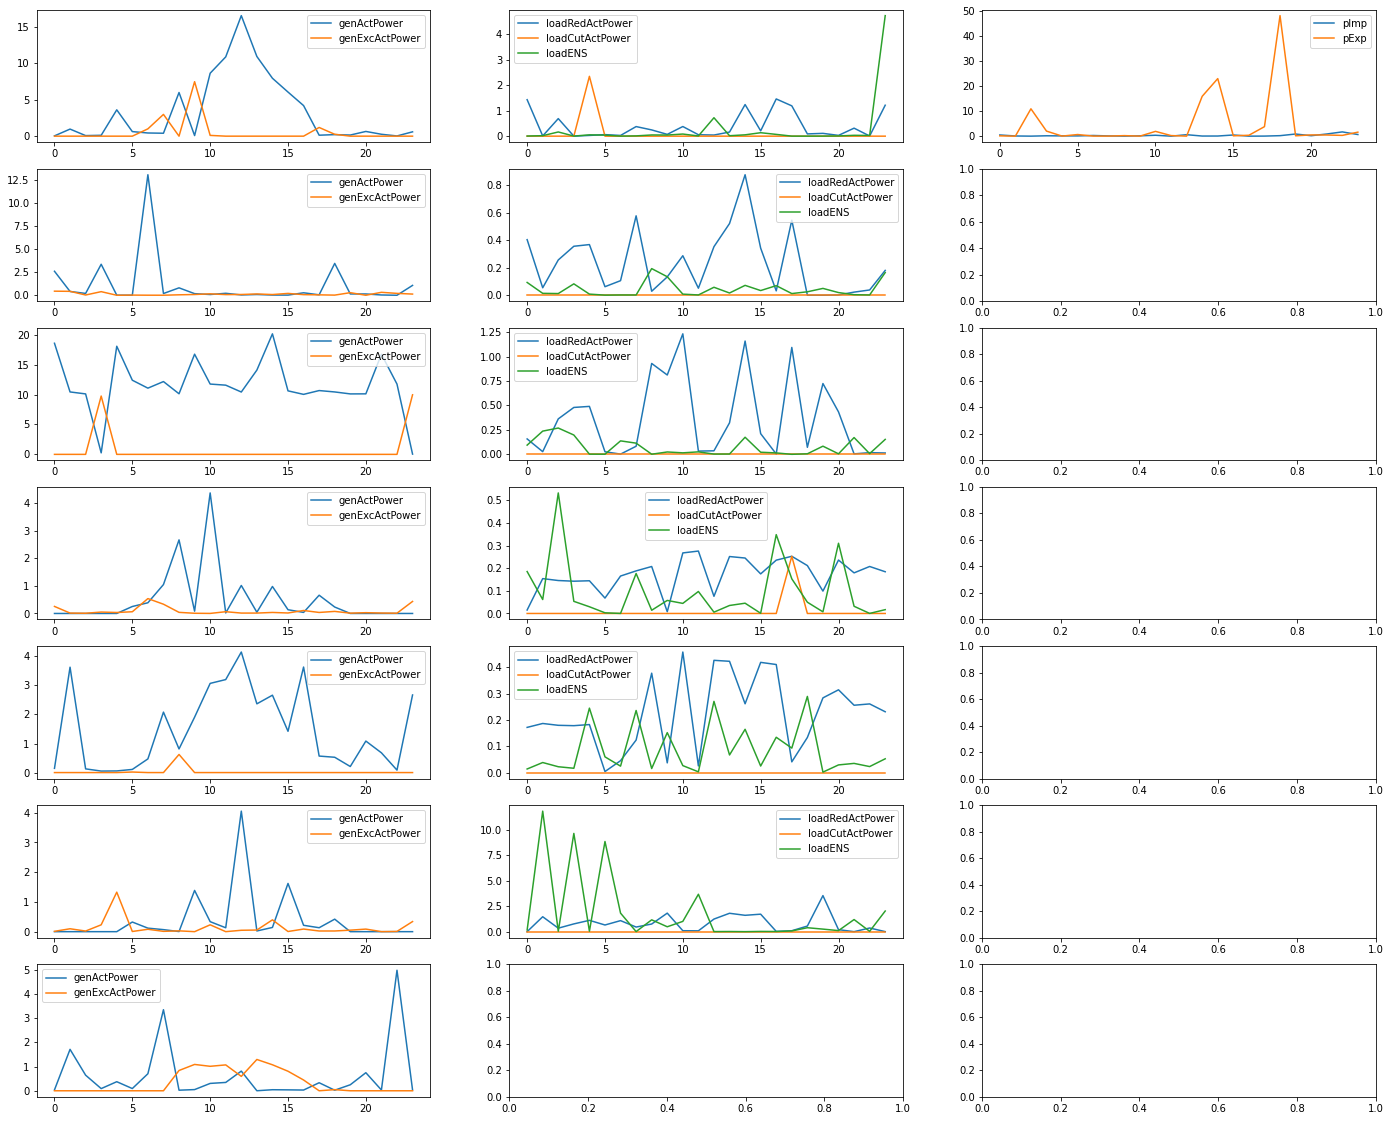

In [82]:
fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(24, 20))

PLOT_SOLUTION = 1

for i in np.arange(7):
    # Generators
    axs[i, 0].plot(decode(trial_results['Solution'][PLOT_SOLUTION], dict_var)['genActPower'][i])
    axs[i, 0].plot(decode(trial_results['Solution'][PLOT_SOLUTION], dict_var)['genExcActPower'][i])
    axs[i, 0].legend(['genActPower', 'genExcActPower'])
    
for i in np.arange(6):
    # Loads
    axs[i, 1].plot(decode(trial_results['Solution'][PLOT_SOLUTION], dict_var)['loadRedActPower'][i])
    axs[i, 1].plot(decode(trial_results['Solution'][PLOT_SOLUTION], dict_var)['loadCutActPower'][i])
    axs[i, 1].plot(decode(trial_results['Solution'][PLOT_SOLUTION], dict_var)['loadENS'][i])
    axs[i, 1].legend(['loadRedActPower', 'loadCutActPower', 'loadENS'])
    
    
axs[0, 2].plot(decode(trial_results['Solution'][PLOT_SOLUTION], dict_var)['pImp'])
axs[0, 2].plot(decode(trial_results['Solution'][PLOT_SOLUTION], dict_var)['pExp'])
axs[0, 2].legend(['pImp', 'pExp'])

#plt.plot(np.sum(decode(trial_results['Solution'][0], dict_var)['genActPower'], axis=0))

plt.show()

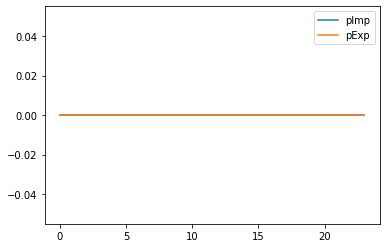

In [43]:
# Imports and Exports

plt.plot(decode(trial_results['Solution'][0], dict_var)['pImp'])
plt.plot(decode(trial_results['Solution'][0], dict_var)['pExp'])

plt.legend(['pImp', 'pExp'])